In [1]:
import json
from convertbng.util import convert_lonlat
import matplotlib.pyplot as plt

In [2]:
# Load the fixed reference data
with open("../data/tiploc.json") as tiploc_file:
    tiploc_data = json.load(tiploc_file)

with open("../data/corpus.json") as corpus_file:
    corpus_data = json.load(corpus_file)["TIPLOCDATA"]

with open("../data/smart.json") as smart_file:
    smart_data = json.load(smart_file)["BERTHDATA"]

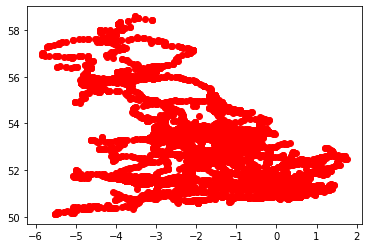

In [3]:
eastings = [int(data["EASTING"]) for data in tiploc_data]
northings = [int(data["NORTHING"]) for data in tiploc_data]
lat_lon = convert_lonlat(eastings, northings)
plt.plot(lat_lon[0], lat_lon[1], 'ro')
plt.show()

In [4]:
output_data = {}

for i, loc in enumerate(tiploc_data):  # We loop through all known locations
    matched_corpus = list(filter(lambda x: x["TIPLOC"] == loc["TIPLOC"], corpus_data))
    for corpus in matched_corpus:
        matched_smart = list(filter(lambda x: x["STANOX"] == corpus["STANOX"], smart_data))
        for smart in matched_smart:
            if smart["STEPTYPE"] == "B":   
                set_data = {
                    "TD": str(smart["TD"]),  # Train describer area for the berth
                    "TIPLOC": str(loc["TIPLOC"]),  # TIPLOC code for the berth
                    "STANOX": str(corpus["STANOX"]),  # STANOX code for the berth
                    "STANME": str(smart["STANME"]),  # STANME code for the berth
                    "DESCRIPTION": str(loc["NAME"]),  # Description of the berth
                    "OFFSET": str(smart["BERTHOFFSET"]),  # event vs TRUST delta t
                    "PLATFORM": str(smart["PLATFORM"]),  # Platform for this berth
                    "EVENT": str(smart["EVENT"]),  # Event associated with this berth
                    "LONGITUDE": lat_lon[0][i],  # Longitude of this berth
                    "LATITUDE": lat_lon[1][i],  # Latitude of this berth
                    "FIXED": True,  # This is a fixed berth in position
                }
                # Add arrival or departure dependent info
                key = None
                if str(smart["EVENT"]) in ["A", "C"]:
                    # A=Arrive Up, C=Arrive Down, therefore use TO berth
                    set_data["BERTH"] = str(smart["TOBERTH"])
                    set_data["LINE"] = str(smart["TOLINE"])
                    key = str(smart["TD"]) + str(smart["TOBERTH"])
                elif str(smart["EVENT"]) in ["B", "D"]:
                    # B=Depart Up, D=Depart Down, therefore use FROM berth
                    set_data["BERTH"] = str(smart["FROMBERTH"])
                    set_data["LINE"] = str(smart["FROMLINE"])
                    key = str(smart["TD"]) + str(smart["FROMBERTH"])
                else:
                    continue

                output_data[key] = set_data

In [5]:
with open('../data/berths.json', 'w') as berths_file:
    json.dump(output_data, berths_file)